In [33]:
#working on writing useful functions to translate/examine HEK data output

import numpy as np
from shapely.geometry import Polygon, Point
from shapely import wkt
from sunpy.time import parse_time
import datetime


In [35]:
#HEK exports certain data as unicode strings. Convert these strings to relevant, useful datatypes

def unicode2datetime(time_array):
    for i, elem in time_array:
        time_array[i] = parse_time(elem)
        
def unicode2polygon(bbox_array):
    if isinstance(bbox_array, basestring):
        bbox_array = wkt.loads(bbox_array)
    else:
        bbox_array = map(lambda x: wkt.loads(x), bbox_array)
#         for i, elem in bbox_array:
#             bbox_array[i] = wkt.loads(elem)
    return bbox_array

In [3]:
#function to determine whether 2 polygons overlap and, if so, in what manner they overlap.
#returns a list of booleans indicating different kinds of overlap 
#input parameters must both be shapely Polygons

def overlap(polygon1, polygon2):
    is_intersect = polygon1.intersects(polygon2)
    if is_intersect == False:
        is_crosses = False
        is_touches = False
        is_contained = False
        is_within = False
    else:
        is_crosses = polygon1.crosses(polygon2)
        is_touches = polygon1.touches(polygon2)
        is_contained = polygon1.contained(polygon2)
        is_within = polygon1.within(polygon2)
    return [is_intersect, is_crosses, is_touches, is_contained, is_within]

In [ ]:
#function to determine the shortest distance between two preselected points on a sphere where we know 
#the radius of the sphere
#would be of use in calculating the distance between the centers of the flux emergence and flare
#nts: maybe change x,y inputs to be tuples later
def geodesic(centroid_1, centroid_2, r):
    x1 = centroid_1.x
    x2 = centroid_2.x
    y1 = centroid_1.y
    y2 = centroid_2.y
    chord = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    s = r*np.arcsin(chord/(2*r))
    return s

In [ ]:
from shapely.geometry import Point

def point_with_z(x, y):
    r = 966
    z = (r**2 - x**2 - y**2)**(0.5)
    point = Point((x, y, z))
    return point

In [4]:
#assign labels to events
#will have to determine how to access num without directly inputting
#keep a global var? access 
def assign_label(event_type, num):
    label = event_type + str(num)

In [5]:
#function to find shortest distance separating two areas
def short_dis_areas(polygon1_area, polygon2_area): #r? will have to add a column for flare area as that's not a given
#account for normalization by looking at disk center?


SyntaxError: invalid syntax (<ipython-input-5-4267f98e1ba1>, line 2)

In [ ]:
#function removes/sythesizes dupiclate entries for the same event

In [52]:
#this function creates a sample data set from our merged "database" of flare events given parameters of start/stop 
#time, radial distance from center, and a minimum cutoff strength
#will have to translate flare strength classifications to numbers/something sortable

import numpy as np
import pandas as pd
import datetime
import csv

def pull_sample_flare(begin_year, begin_month, begin_day, end_year, end_month, end_day, max_dist_frm_center, min_strength):
    inputFile = 'flares_database.csv'
    flare_set = pd.read_csv(inputFile, delimiter = ',', header = 0)
    flare_set = flare_set.ix[flare_set['start_year']>=begin_year]
    flare_set = flare_set.ix[flare_set['stop_year']<=end_year]
    flare_set = flare_set.ix[flare_set['start_month']>=begin_month]
    flare_set = flare_set.ix[flare_set['stop_month']<=end_month]
    flare_set = flare_set.ix[flare_set['start_day']>=begin_day]
    flare_set = flare_set.ix[flare_set['stop_day']<=end_day]
    flare_set = flare_set.ix[flare_set['dist_frm_center']<=max_dist_frm_center]
    flare_set = flare_set.ix[flare_set['fl_peakflux']<=min_strength]
    return flare_set

def pull_sample_flare_1(inputFile, begin_time, end_time, max_dist_frm_center, min_strength):
    flare_set = pd.read_csv(inputFile, delimiter = ',', header = 0)
    flare_set['event_starttime'] = map(parse_time, flare_set['event_starttime'])
    flare_set['event_endtime'] = map(parse_time, flare_set['event_endtime'])
    flare_set = flare_set.ix[flare_set['event_starttime']>=begin_time]
    flare_set = flare_set.ix[flare_set['event_endtime']<=end_time]
    flare_set = flare_set.ix[flare_set['dist_frm_center']<=max_dist_frm_center]
    flare_set = flare_set.ix[flare_set['fl_peakflux']>=min_strength]
    return flare_set

begin_time = parse_time('2014-01-01T02:34:30')
end_time = parse_time('2014-01-21T02:34:30')
max_d = 100.0
min_strength = 100.0

print pull_sample_flare_1('flares_database.csv', begin_time, end_time, max_dist_frm_center, min_strength)

                       SOL_standard     event_starttime       event_endtime  \
0    SOL2014-01-01T06:45:00L096C094 2014-01-01 06:45:00 2014-01-01 06:52:00   
1    SOL2014-01-01T06:45:00L096C094 2014-01-01 06:45:00 2014-01-01 06:52:00   
2    SOL2014-01-01T06:45:00L186C090 2014-01-01 06:45:00 2014-01-01 06:52:00   
3    SOL2014-01-01T07:21:00L233C102 2014-01-01 07:21:00 2014-01-01 07:29:00   
4    SOL2014-01-01T07:21:00L233C102 2014-01-01 07:21:00 2014-01-01 07:29:00   
5    SOL2014-01-01T15:40:00L091C096 2014-01-01 15:40:00 2014-01-01 16:09:00   
6    SOL2014-01-01T15:40:00L181C090 2014-01-01 15:40:00 2014-01-01 16:09:00   
7    SOL2014-01-01T18:40:00L225C106 2014-01-01 18:40:00 2014-01-01 19:03:00   
8    SOL2014-01-01T18:40:00L227C104 2014-01-01 18:40:00 2014-01-01 19:03:00   
9    SOL2014-01-01T21:54:00L088C097 2014-01-01 21:54:00 2014-01-01 22:22:00   
10   SOL2014-01-01T22:30:00L088C097 2014-01-01 22:30:00 2014-01-01 22:45:00   
11   SOL2014-01-02T02:24:00L085C095 2014-01-02 02:24

In [31]:
inputFile = 'look_at_ef_data.csv'

def pull_sample_ef(inputFile, begin_time, end_time, delta_t):
    ef_set = pd.read_csv(inputFile, delimiter = ',', header = 0)
    ef_set['event_starttime'] = map(parse_time, ef_set['event_starttime'])
    ef_set['event_endtime'] = map(parse_time, ef_set['event_endtime'])
    ef_set = ef_set.ix[ef_set['event_starttime']>=(begin_time-delta_t)]
    ef_set = ef_set.ix[ef_set['event_endtime']<=(end_time-delta_t)]

    return ef_set
begin_time = parse_time('2014-01-01T02:34:30')
end_time = parse_time('2014-01-21T02:34:30')
delta_t=datetime.timedelta(hours = 0, minutes = 30, seconds = 0)
print pull_sample_ef(begin_time, end_time, delta_t)

     Unnamed: 0                    SOL_standard active  ar_compactnesscls  \
3             3  SOL2014-01-01T02:18:45L206C084   True                NaN   
4             4  SOL2014-01-01T02:18:45L223C117   True                NaN   
5             5  SOL2014-01-01T02:30:45L233C103   True                NaN   
6             6  SOL2014-01-01T03:42:45L207C084   True                NaN   
7             7  SOL2014-01-01T07:18:45L232C103   True                NaN   
8             8  SOL2014-01-01T07:18:45L211C104   True                NaN   
9             9  SOL2014-01-01T07:54:45L234C094   True                NaN   
10           10  SOL2014-01-01T07:54:45L215C088   True                NaN   
11           11  SOL2014-01-01T08:06:45L145C114   True                NaN   
12           12  SOL2014-01-01T08:18:45L178C060   True                NaN   
13           13  SOL2014-01-01T08:54:45L127C083   True                NaN   
14           14  SOL2014-01-01T08:54:45L223C113   True                NaN   

In [ ]:
def pull_sample_CME(inputFile, begin_time, end_time, delta_t):
    cme_set = pd.read_csv(inputFile, delimiter = ',', header = 0)
    cme_set['event_starttime'] = map(parse_time, cme_set['event_starttime'])
    cme_set['event_endtime'] = map(parse_time, cme_set['event_endtime'])
    cme_set = cme_set.ix[cme_set['event_starttime']>=(begin_time-delta_t)]
    cme_set = cme_set.ix[cme_set['event_endtime']<=(end_time-delta_t)]

    return cme_set

In [ ]:
def pull_sample(inputFile, begin_time, end_time, delta_t):
    df = pd.read_csv(inputFile, delimiter = ',', header = 0)
    df['event_starttime'] = map(parse_time, df['event_starttime'])
    df['event_endtime'] = map(parse_time, df['event_endtime'])
    df = df.ix[df['event_starttime']>=(begin_time-delta_t)]
    df = df.ix[df['event_endtime']<=(end_time-delta_t)]

    return df

In [ ]:
def spatial_flux_check(flare_poly, ef_poly, spatial_sep, df, index):
    if geodesic(flare_poly.centroid, ef_poly.centroid)<= spatial_sep:
        return df['indentifier'][index]

In [1]:
#function to determine whether a flare corresponds with a flux emergence

def associate_ef(inputFile, begin_year, begin_month, begin_day, end_year, end_month, end_day, max_dist_frm_center, 
                 min_strength, temporal_sep_hr, temporal_sep_min, temporal_sep_sec, spatial_sep, output2file=False, 
                 out_file = None):
    delta_t = datetime.timedelta(hours = temporal_sep_hr, minutes = temporal_sep_min, seconds = temporal_sep_sec)
    begin_time = datetime.datetime(begin_year, begin_month, begin_day)
    end_time = datetime.datetime(end_year, end_month, end_day) 
    flare_set = pull_sample_flare_1(begin_time, end_time, max_dist_frm_center, min_strength)
    ef_set = pull_sample(inputFile, begin_time, end_time, delta_t)
    r = 966
    
    is_ef = [0 for i in range(flare_set.shape[0])]
    associated_ef = []
    i = -1
    for elem in flare_set['event_starttime']:
        i += 1
        start_ef = elem-delta_t
        ef_search = ef_set.ix[ef_set['event_endtime']>=start_ef]
        ef_search = ef_search.ix[ef_search['event_endtime']<=elem]
        if ef_search.empty == False:
            fl_point = Point((flare_set['hpc_x'].values[i], flare_set['hpc_y'].values[i]))
            #keep in mind, Point in HPC units 
            good_ef = []
            if ef_search.shape[0] == 1:
                ef_poly = wkt.loads(ef_search['hpc_bbox'].values[0])
                chord = fl_point.distance(ef_poly)
                s = r*np.arcsin(chord/(2*r))
                if s <= spatial_sep:
                    good_ef.append(ef_search['SOL_standard'].values[0])
                else: good_ef = [0]
            else:
                ef_search['hpc_bbox'] = unicode2polygon(ef_search['hpc_bbox'])
                j = 0
                found_flux = False
                for elem in ef_search['hpc_bbox'].values:
                    chord = fl_point.distance(elem)
                    s = r*np.arcsin(chord/(2*r))
                    if s <= spatial_sep:
                        good_ef.append(ef_search['SOL_standard'].values[j])   
                        found_flux = True
                    j+=1
                if found_flux == False: good_ef = [0]
        else: good_ef = [0]
        associated_ef.append(good_ef)
    k = 0
    for elem in associated_ef:
        if elem!=[0]:
            is_ef[k] = 1
        k+=1
    flare_set.loc[:, 'is_ef'] = is_ef
    flare_set.loc[:, 'associated_ef'] = associated_ef
    
    if output2file == True:
        if out_file == None:
             out_file = ('flare_search_'+str(begin_time)+'_'+ str(end_time)+'_'+str(max_dist_from_center)+
                         '_'+str(min_strength)+'.csv')
        flare_keywords = list(np.genfromtxt('flare_keywords.csv', delimiter=',', dtype=str))
        flare_keywords.extend(['is_ef','associated_ef'])

        flare_set.to_csv(path_or_buf=out_file, columns = flare_keywords, index = False)
        
    return flare_set   
        
ff(2014, 1, 2, 2014, 1, 19, 100, 100, 0, 30, 0, 300, output2file=True, out_file = None)  

NameError: global name 'datetime' is not defined

In [ ]:
def associate_event(inputFile, begin_year, begin_month, begin_day, end_year, end_month, end_day, max_dist_frm_center, 
                 min_strength, temporal_sep_hr, temporal_sep_min, temporal_sep_sec, spatial_sep, output2file=False, 
                 out_file = None, post_flare = False):
    delta_t = datetime.timedelta(hours = temporal_sep_hr, minutes = temporal_sep_min, seconds = temporal_sep_sec)
    begin_time = datetime.datetime(begin_year, begin_month, begin_day)
    end_time = datetime.datetime(end_year, end_month, end_day) 
    flare_set = pull_sample_flare_1(begin_time, end_time, max_dist_frm_center, min_strength)
    event_set = pull_sample(inputFile, begin_time, end_time, delta_t)
    r = 966
    
    is_event = [0 for i in range(flare_set.shape[0])]
    associated_event = []
    i = -1
    for elem in flare_set['event_starttime']:
        i += 1
        if post: 
            end_event = elem+delta_t
            event_search = event_set.ix[event_set['event_endtime']>=elem]
            event_search = event_search.ix[event_search['event_endtime']<=end_event]  
        else:
            start_event = elem-delta_t
            event_search = event_set.ix[event_set['event_endtime']>=start_event]
            event_search = event_search.ix[event_search['event_endtime']<=elem]
        if event_search.empty == False:
            fl_point = Point((flare_set['hpc_x'].values[i], flare_set['hpc_y'].values[i]))
            #keep in mind, Point in HPC units 
            good_event = []
            if event_search.shape[0] == 1:
                event_poly = wkt.loads(event_search['hpc_bbox'].values[0])
                chord = fl_point.distance(event_poly)
                s = r*np.arcsin(chord/(2*r))
                if s <= spatial_sep:
                    good_event.append(event_search['SOL_standard'].values[0])
                else: good_event = [0]
            else:
                event_search['hpc_bbox'] = unicode2polygon(event_search['hpc_bbox'])
                j = 0
                found_event = False
                for elem in event_search['hpc_bbox'].values:
                    chord = fl_point.distance(elem)
                    s = r*np.arcsin(chord/(2*r))
                    if s <= spatial_sep:
                        good_event.append(event_search['SOL_standard'].values[j])   
                        found_event = True
                    j+=1
                if found_event == False: good_event = [0]
        else: good_event = [0]
        associated_event.append(good_event)
    k = 0
    for elem in associated_event:
        if elem!=[0]:
            is_event[k] = 1
        k+=1
    flare_set.loc[:, 'is_event'] = is_event
    flare_set.loc[:, 'associated_event'] = associated_event
    
    if output2file:
        if out_file == None:
             out_file = ('flare_search_'+str(begin_time)+'_'+ str(end_time)+'_'+str(max_dist_from_center)+
                         '_'+str(min_strength)+'.csv')
        flare_keywords = list(np.genfromtxt('flare_keywords.csv', delimiter=',', dtype=str))
        flare_keywords.extend(['is_event','associated_event'])

        flare_set.to_csv(path_or_buf=out_file, columns = flare_keywords, index = False)
        
    return flare_set   

In [ ]:
#original middle sequence for ff

for elem in flare_set['event_starttime']:
        i += 1
        start_ef = elem-delta_t
        ef_search = ef_set.ix[ef_set['event_endtime']>=start_ef]
        ef_search = ef_search.ix[ef_search['event_endtime']<=elem]
        if ef_search.empty == False:
            fl_hpc_bbox = np.array(flare_set['hpc_bbox'])
            flare_poly = wkt.loads(fl_hpc_bbox[i])
            good_ef = []
            if ef_search.shape[0] == 1:
                ef_poly = wkt.loads(ef_search['hpc_bbox'].values[0])
                if geodesic(flare_poly.centroid, ef_poly.centroid, 966)<= spatial_sep:
                    good_ef.append(ef_search['SOL_standard'].values[0])
                else: good_ef = [0]
            else:
                ef_search['hpc_bbox'] = unicode2polygon(ef_search['hpc_bbox'])
                j = 0
                for elem in ef_search['hpc_bbox'].values:
                    if geodesic(flare_poly.centroid, elem.centroid, 966)<= spatial_sep:
                        good_ef.append(ef_search['SOL_standard'].values[j])
                    j+=1
                    else: good_ef = [0]
        else: good_ef = [0]
        associated_ef.append(good_ef)

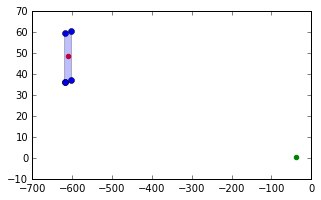

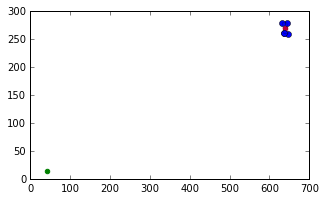

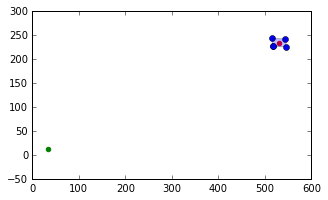

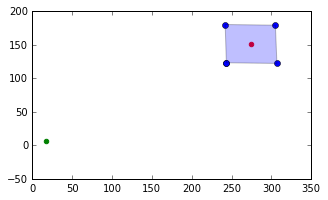

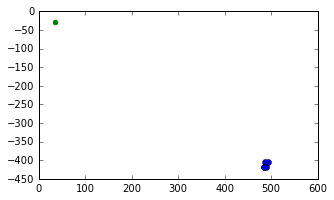

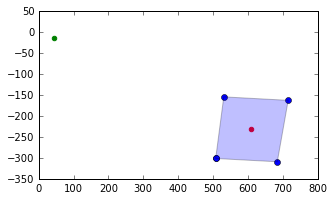

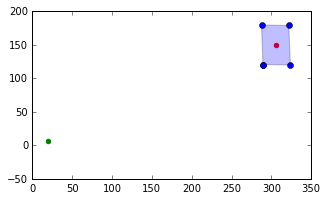

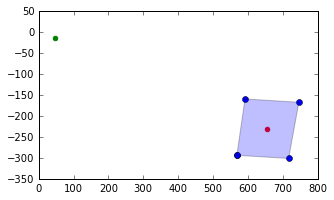

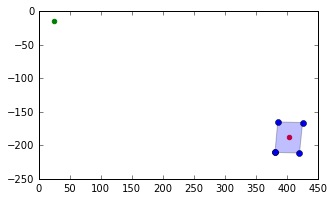

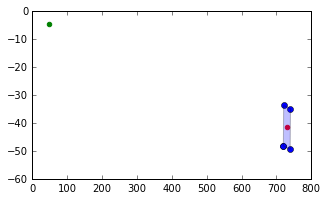

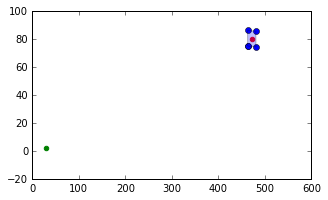

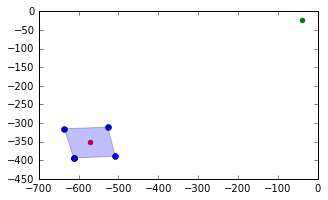

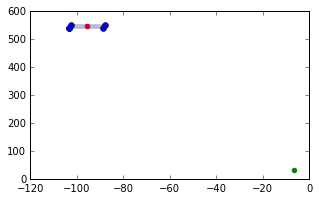

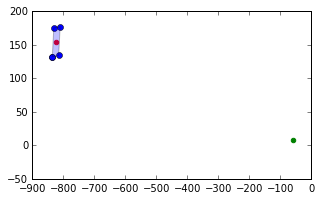

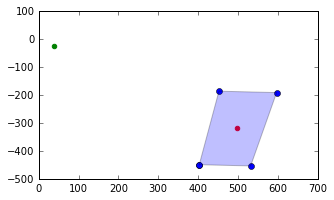

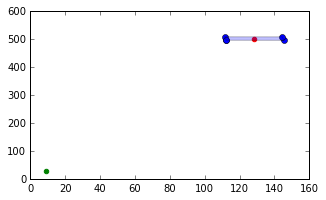

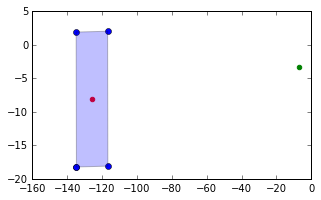

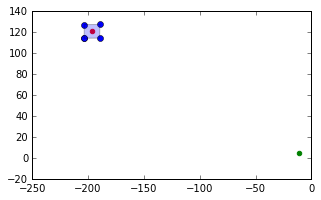

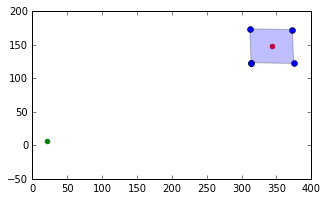

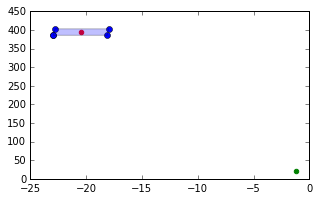

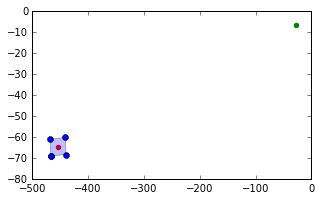

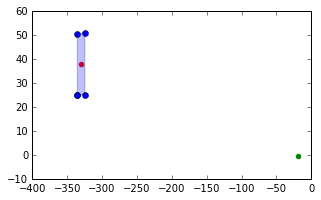

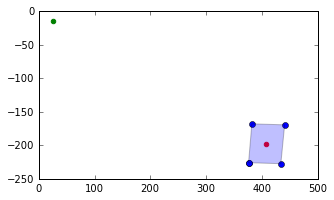

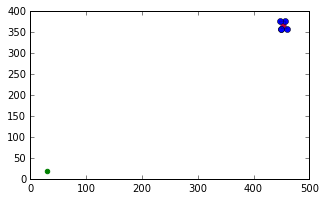

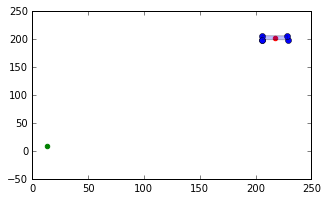

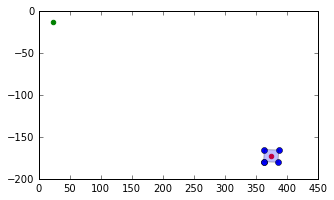

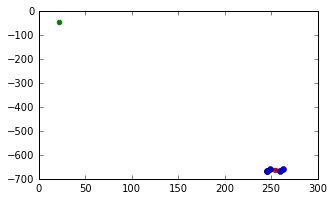

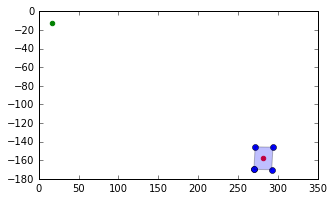

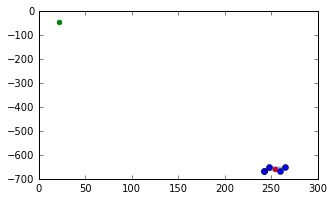

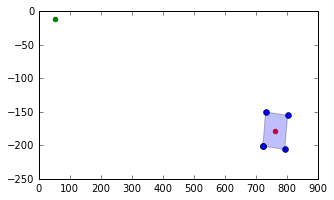

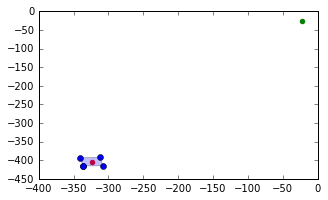

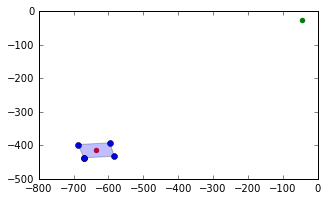

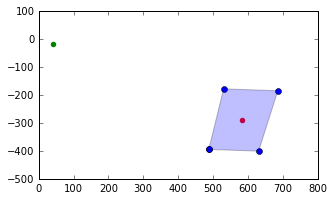

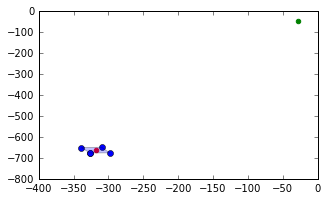

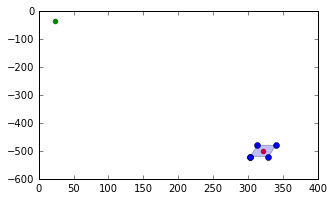

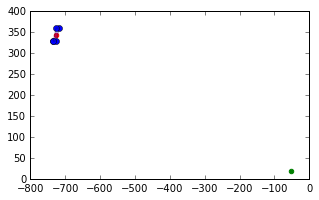

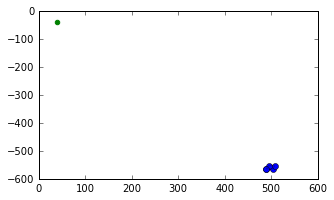

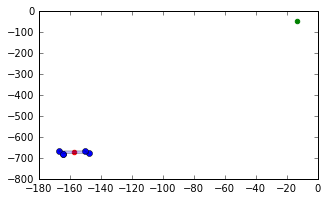

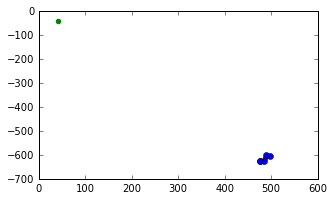

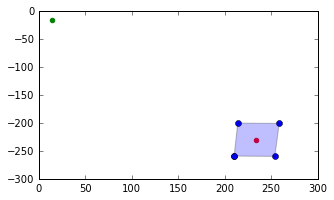

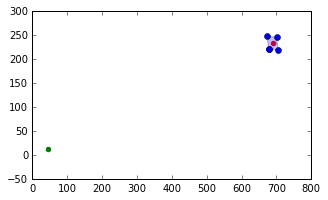

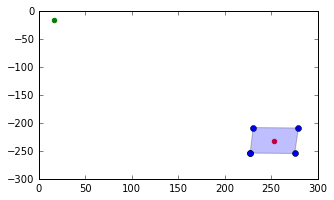

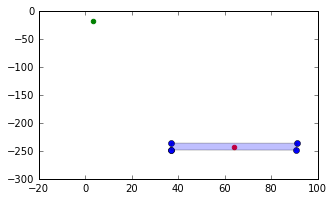

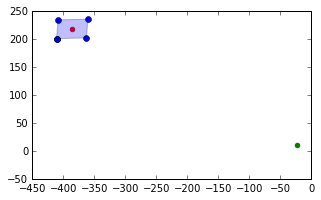

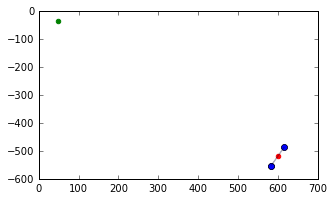

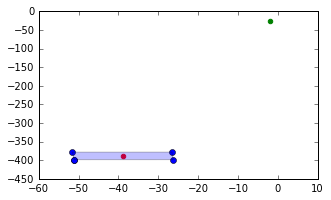

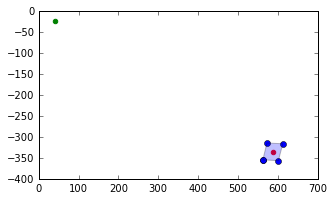

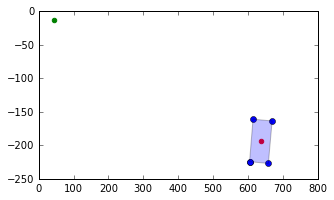

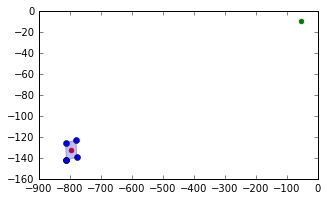

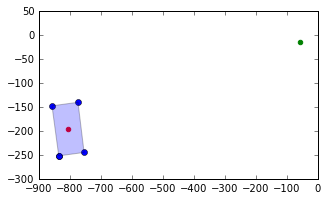

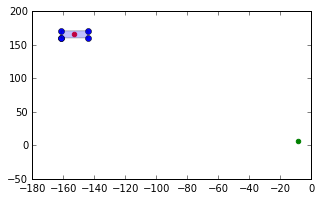

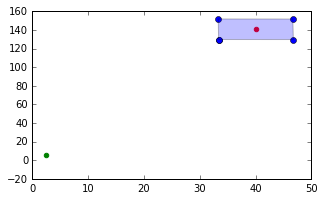

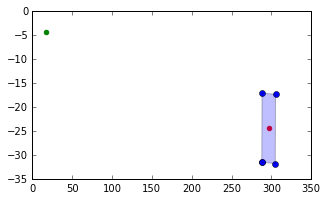

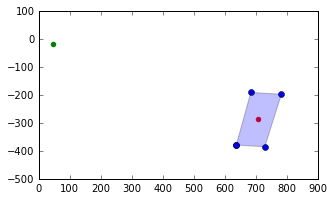

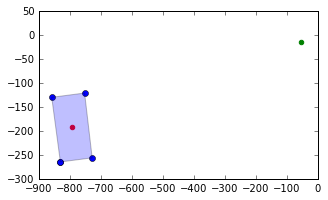

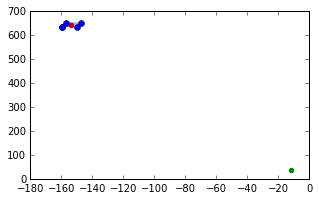

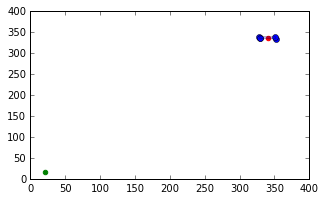

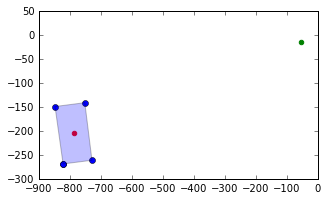

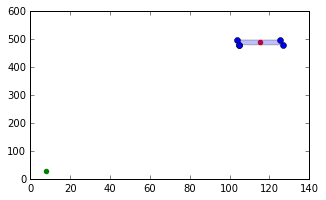

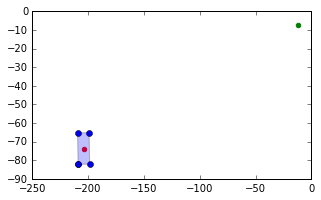

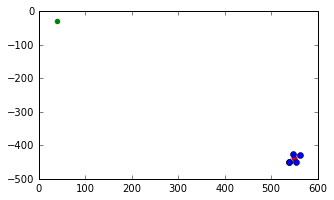

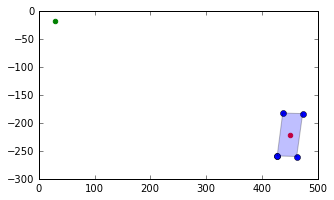

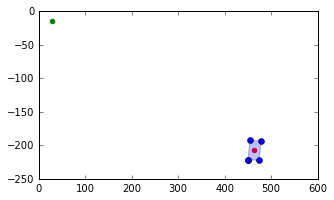

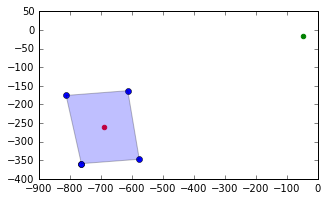

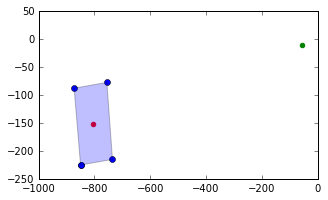

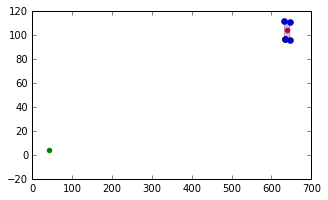

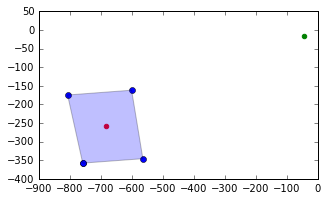

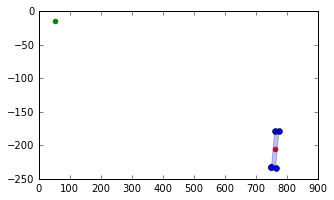

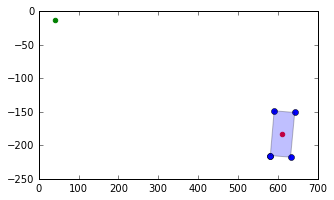

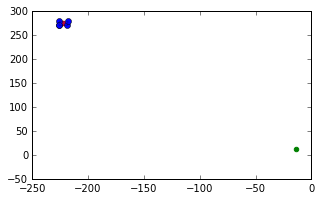

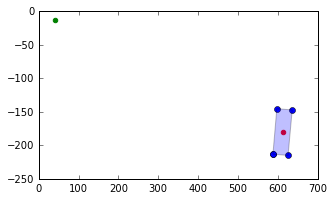

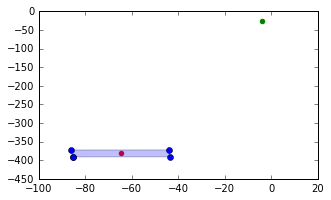

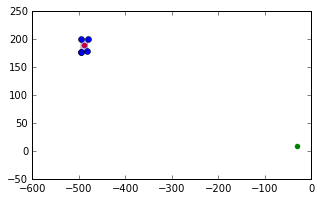

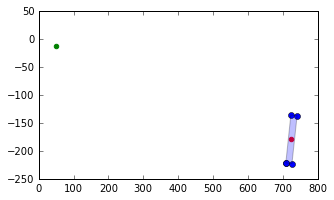

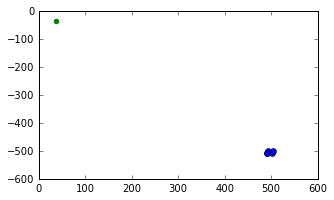

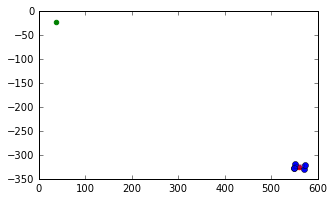

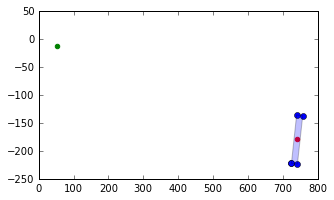

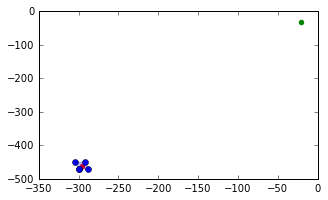

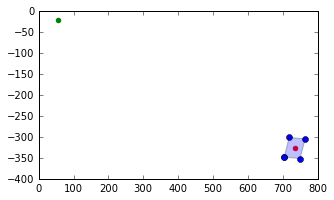

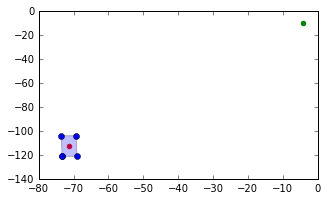

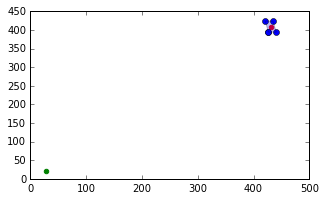

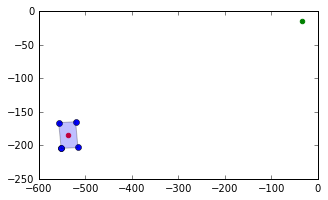

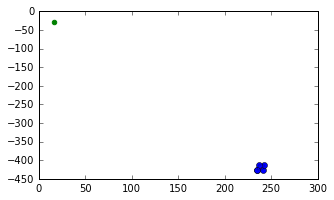

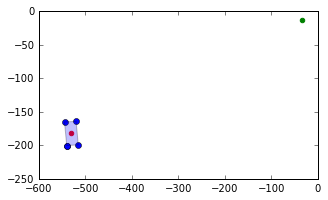

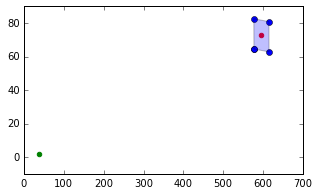

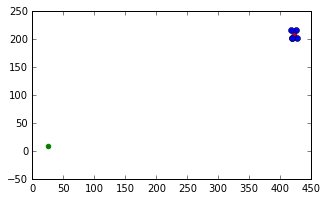

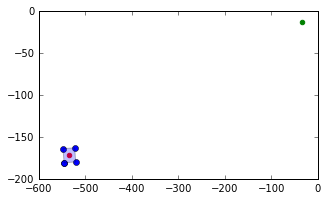

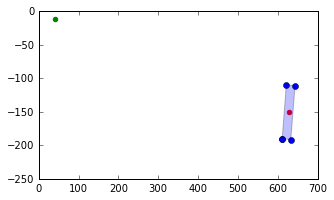

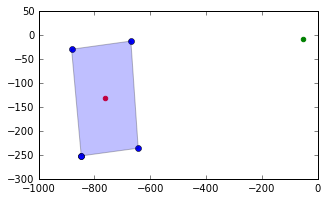

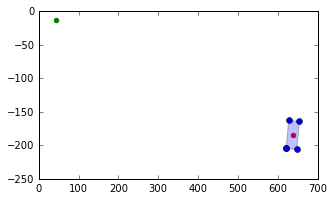

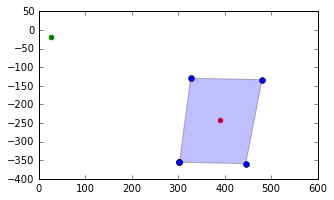

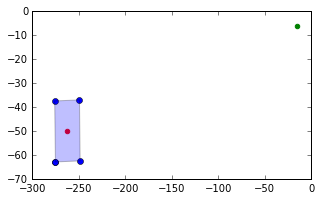

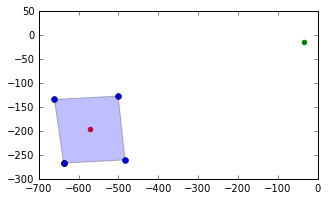

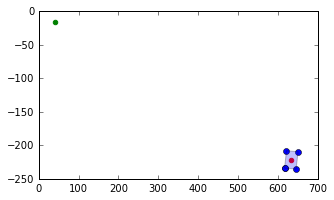

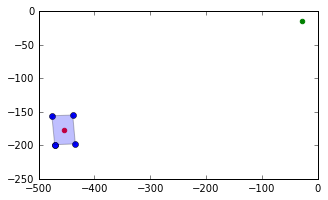

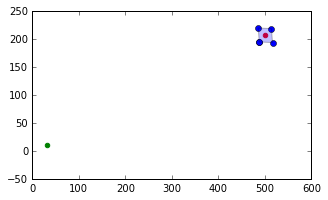

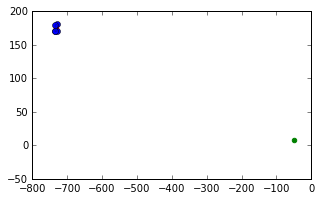

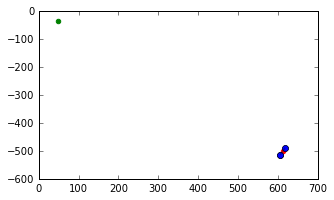

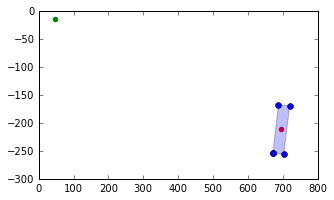

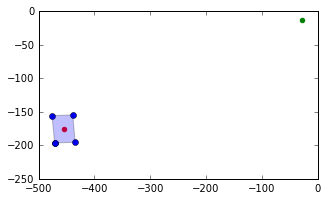

In [24]:
#visualize polygon given by HEK with polygon's centriod and HEK's mean coordinates
%matplotlib inline

import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import pandas as pd
import numpy as np
from shapely import wkt


inputFile = 'look_at_ef_data.csv'

flare_set = pd.read_csv(inputFile, delimiter = ',', header = 0)

fl_hpc_bbox = np.array(flare_set['hpc_bbox'])

def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, 'o', zorder=1)

for i in range(100):
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)
    flare_poly = wkt.loads(fl_hpc_bbox[i])
    
    plot_coords(ax, flare_poly.exterior)

    patch = PolygonPatch(flare_poly, alpha=0.25, zorder=2)
    ax.add_patch(patch)
    plt.scatter(flare_poly.centroid.x, flare_poly.centroid.y, color = 'red')
    plt.scatter(flare_set['event_coord1'].values[i], flare_set['event_coord2'].values[i], color = 'green')

    '''learned that all flare events' polygons are rectangles. event_coords seems to be accurate. for ef,
    polygons are a more diverse set of quadrilaterals. event_coords seems to be unaccurate, only seems to
    fall within a tiny box surrounding the orgin--> use centroid'''

In [55]:
def dist_frm_center(x, y):
    r = 966
    z = (r**2 - x**2 - y**2)**(0.5)
    dist = (x**2 + y**2 + (z-r)**2)**(0.5)
    return dist


0.0

In [ ]:
def in_range(start_range, end_range, time_in_q):
    indices_of_in_range_events = []
    for i, elem in enumerate(start_range):
        if time_in_q>=elem:
            if time_in_q<=end_range[i]:
                indices_of_in_range_events.append(i)
    return indices_of_in_range_events
    

In [ ]:
def associate_ar():
    '11931_2014-01-01T20/00/00_2014-01-01T22/48/00.csv'
    map(lambda x: in_range(start_range, end_range, x), fl_start)
    